# Tutorial for a new pointing API and a pointing systematics.


In [1]:
%load_ext autoreload
%autoreload 2
import litebird_sim as lbs
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
import tomlkit
import logging

logging.getLogger("healpy").setLevel(logging.WARNING)

Let's define useful function to generate `Simulation` and list of `DetectorInfo`.


In [2]:
telescope = "LFT"
start_time = 0

imo_version = "vPTEP"
imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)

duration_s = 10
sampling_hz = 1.0
random_seed = 12345


def gen_simulation_and_dets(
    telescope,
    duration_s,
    sampling_hz,
    random_seed,
    hwp_rpm=None,
    scan_strategy=True,
):
    """Generate a simulation and detectors with a argument of scan_strategy.
    If scan_strategy is True, the scanning strategy is set by the IMO file.
    If scan_strategy is False, the spacecraft stops spinning and precession.
    """
    sim = lbs.Simulation(
        start_time=start_time, duration_s=duration_s, random_seed=random_seed
    )
    if scan_strategy:
        sim.set_scanning_strategy(
            imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/",
            delta_time_s=1.0 / sampling_hz,
        )
    else:
        sim.set_scanning_strategy(
            scanning_strategy=lbs.SpinningScanningStrategy(
                spin_sun_angle_rad=np.deg2rad(45.0),
                spin_rate_hz=0.0,
                precession_rate_hz=0.0,
            ),
            delta_time_s=1.0 / sampling_hz,
        )
    sim.set_instrument(
        lbs.InstrumentInfo.from_imo(
            imo,
            f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
        )
    )

    if hwp_rpm is not None:
        sim.set_hwp(lbs.IdealHWP(hwp_rpm * 2 * np.pi / 60))
        sim.instrument.hwp_rpm = hwp_rpm
    else:
        sim.set_hwp(lbs.IdealHWP(sim.instrument.hwp_rpm * 2 * np.pi / 60))
    dets = []
    path_of_toml = "../test/pointing_sys_reference/mock_focalplane.toml"
    with open(path_of_toml, "r", encoding="utf-8") as toml_file:
        toml_data = tomlkit.parse(toml_file.read())
        for i in range(len(toml_data[telescope])):
            det = lbs.DetectorInfo.from_dict(toml_data[telescope][f"det_{i:03}"])
            det.sampling_rate_hz = sampling_hz
            dets.append(det)
    return sim, dets

In the new pointing API allows to calculate pointing in the method of `.Observation`
To obtain all detectors pointing that you specified, you just call `Observation.get_pointings("all")` as below:


In [3]:
sim, dets = gen_simulation_and_dets(telescope, duration_s, sampling_hz, random_seed)
sim.create_observations(detectors=dets)

lbs.prepare_pointings(
    sim.observations, sim.instrument, sim.spin2ecliptic_quats, hwp=sim.hwp
)

pointings, hwp_angle = sim.observations[0].get_pointings("all")

The same result can be obtained by accessing each instance using a for loop as follows:


In [4]:
pointings_ = []
for cur_obs in sim.observations:
    for det_idx in range(cur_obs.n_detectors):
        pnt, _ = cur_obs.get_pointings(det_idx, pointings_dtype=np.float32)
        pointings_.append(pnt[0])
pointings_ = np.array(pointings_)

assert np.allclose(pointings, pointings_)

Thanks to the new pointing API, we can control the time dependency of the quaternion to generate pointings.
The `Class: PointingSys` contains essential functionality to simulate a systematics that can happen around pointing, e.g. constant offset, vibration and so on.

These systematics need to be simulated on a specific coordinate, such as a Forcal plane coordinate and a spacecraft coordinate.
`PointingSys` can simulate several situations of pointing systematics:

- Forcal plane coordinate
  - Time-independent
    - Global offset: Each detector has an offset of the same magnitude and direction.
    - Individual offset per detector: Each detector has offset of different magnitude and direction.
  - Time-dependent
    - Global offset: Each detector has the same disturbance.
    - Individual disturbance det. by det: Each detector has different disturbance.
- Spacecraft Coordinate
  - Time independent
    - Global offset: Spacecraft misinterprets its spin axis.
  - Time-dependent
    - Global disturbance: The whole spacecraft is affected by the same perturbation, e.g. due to a cryogenic system, internal noise of the star tracker.

Here we describe the use of `PointingSys` to simulate each point.


## FP coord / time-independent / global offset


In [5]:
axes = ["x", "y", "z"]  # rotation axis for the offset in the focal plane coordinate
pointings_list = []
global_offset_deg = 10.0

for ax in axes:
    sim_sys, dets_sys = gen_simulation_and_dets(
        telescope, duration_s, sampling_hz, random_seed
    )

    # Define the instance of the `PointingSys`
    pntsys = lbs.PointingSys(sim_sys, dets_sys)
    # Add the global offset to the focal plane
    pntsys.focalplane.add_offset(np.deg2rad(global_offset_deg), ax)

    sim_sys.create_observations(detectors=dets_sys)
    lbs.prepare_pointings(
        sim_sys.observations,
        sim_sys.instrument,
        sim_sys.spin2ecliptic_quats,
        hwp=sim_sys.hwp,
    )

    pointings_sys, hwp_angle = sim_sys.observations[0].get_pointings("all")
    pointings_list.append(pointings_sys)

To check the pointing, let's define the function to make hitmap:


In [6]:
def get_hitmap(nside, pointings):
    npix = hp.nside2npix(nside)
    ipix = hp.ang2pix(nside, pointings[:, :, 0], pointings[:, :, 1])
    hitmap, _ = np.histogram(ipix, bins=np.arange(npix + 1))
    return hitmap

We can see how the global offset is injected in the pointings in the below hitmap which is calculated with a single timestamp:


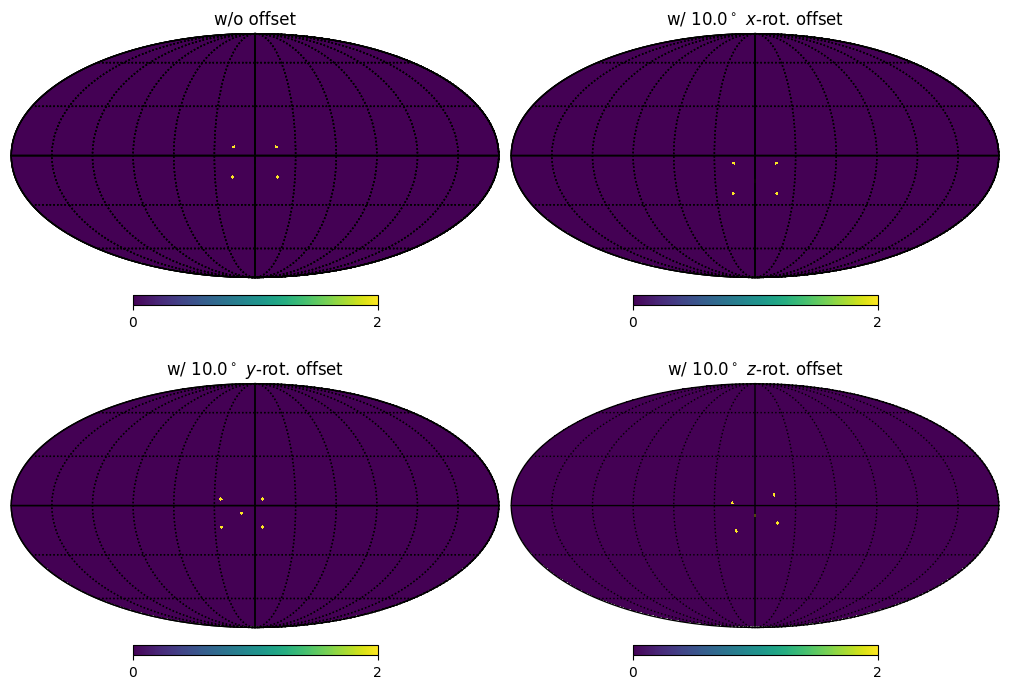

In [7]:
nside = 32
hitmap = get_hitmap(
    nside,
    pointings[
        :,
        :1,
        :,
    ],
)

plt.figure(figsize=(10, 7))
hp.mollview(hitmap, sub=(2, 2, 1), title="w/o offset")
hp.graticule()
for i, ax in enumerate(axes):
    hitmap_sys = get_hitmap(nside, pointings_list[i][:, :1])
    hp.mollview(
        hitmap_sys,
        sub=(2, 2, i + 2),
        title=rf"w/ {global_offset_deg}$^\circ$ ${ax}$-rot. offset",
    )
    hp.graticule()

## FP coord / time-independent / individual offset det. by det.


In [8]:
pointings_list = []

sim_sys, dets_sys = gen_simulation_and_dets(
    telescope, duration_s, sampling_hz, random_seed
)
pntsys = lbs.PointingSys(sim_sys, dets_sys)
det1_offset = 10.0
uncommon_offsets_deg = [
    0,
    0,
    det1_offset,
    det1_offset,
    0,
    0,
    0,
    0,
    0,
    0,
]  # [det0_top, det0_bottom, det1_top, det1_bottom,...]

# Just you need to put array of the offsets in the focal plane coordinate
pntsys.focalplane.add_offset(np.deg2rad(uncommon_offsets_deg), "x")
pntsys.focalplane.add_offset(np.deg2rad(uncommon_offsets_deg), "y")

sim_sys.create_observations(detectors=dets_sys)
lbs.prepare_pointings(
    sim_sys.observations,
    sim_sys.instrument,
    sim_sys.spin2ecliptic_quats,
    hwp=sim_sys.hwp,
)

pointings_sys, hwp_angle = sim_sys.observations[0].get_pointings("all")
pointings_list.append(pointings_sys)

One detector that has turned 10 deg. on the $x$-axis and then 10 deg. on the $y$-axis can be identified.


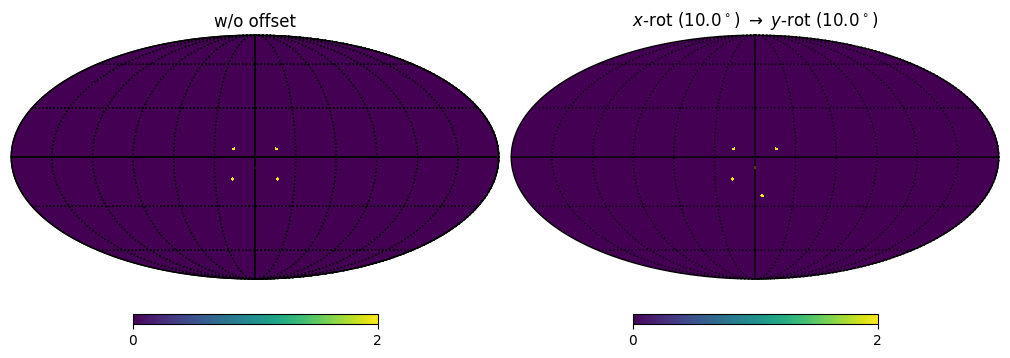

In [9]:
hitmap = get_hitmap(
    nside,
    pointings[
        :,
        :1,
        :,
    ],
)

plt.figure(figsize=(10, 7))
hp.mollview(hitmap, sub=(1, 2, 1), title="w/o offset")
hp.graticule()

hitmap_sys = get_hitmap(nside, pointings_list[0][:, :1])
hp.mollview(
    hitmap_sys,
    sub=(1, 2, 2),
    title=rf"$x$-rot ({det1_offset}$^\circ$) $\rightarrow$ $y$-rot ({det1_offset}$^\circ$)",
)
hp.graticule()

## FP coord / time-dependent / global disturbance


In [10]:
duration_s = 10
sampling_hz = 10.0

sim_sys, dets_sys = gen_simulation_and_dets(
    telescope, duration_s, sampling_hz, random_seed, scan_strategy=False
)

nquats = sim_sys.spin2ecliptic_quats.quats.shape[0]

noise_rad_array_x = np.zeros(nquats)
noise_rad_array_y = np.zeros(nquats)
noise_sigma_deg = 3.0

# make a white noise with the unit of radian.
lbs.add_white_noise(
    noise_rad_array_x, sigma=np.deg2rad(noise_sigma_deg), random=sim_sys.random
)
lbs.add_white_noise(
    noise_rad_array_y, sigma=np.deg2rad(noise_sigma_deg), random=sim_sys.random
)

pntsys = lbs.PointingSys(sim_sys, dets_sys)

# Add the white noise to the focal plane
pntsys.focalplane.add_disturb(noise_rad_array_x, "x")
pntsys.focalplane.add_disturb(noise_rad_array_y, "y")

pointings_list = []
sim_sys.create_observations(detectors=dets_sys)
lbs.prepare_pointings(
    sim_sys.observations,
    sim_sys.instrument,
    sim_sys.spin2ecliptic_quats,
    hwp=sim_sys.hwp,
)

pointings_list, _ = sim_sys.observations[0].get_pointings("all")

Within 10 secconds observation with 10 Hz sampling rate, we can see the gaussian stracture in the hitmap due to the white noise that we injected.


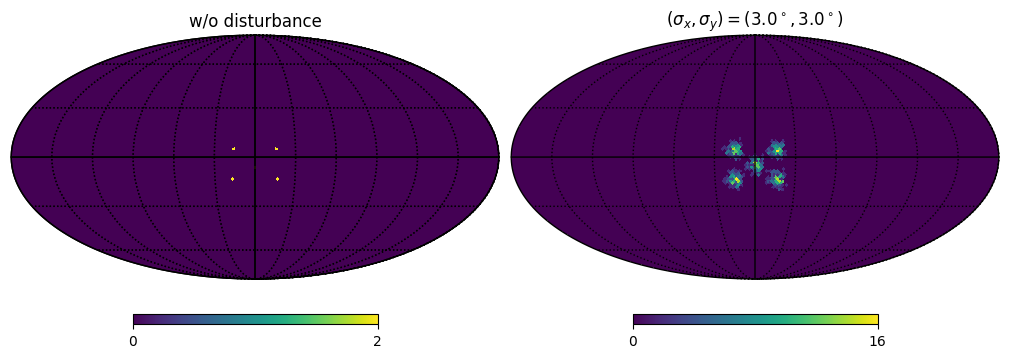

In [11]:
nside = 32
hitmap = get_hitmap(
    nside,
    pointings[
        :,
        :1,
        :,
    ],
)

plt.figure(figsize=(10, 7))
hp.mollview(hitmap, sub=(1, 2, 1), title="w/o disturbance")
hp.graticule()

hitmap_sys = get_hitmap(nside, pointings_list)
hp.mollview(
    hitmap_sys,
    sub=(1, 2, 2),
    title=f"$(\sigma_x,\sigma_y)=({noise_sigma_deg}^\circ, {noise_sigma_deg}^\circ)$",
)
hp.graticule()

## FP coord / time-dependent / individual disturbance det. by det.


In [12]:
duration_s = 10
sampling_hz = 10.0

sim_sys, dets_sys = gen_simulation_and_dets(
    telescope, duration_s, sampling_hz, random_seed, scan_strategy=False
)

nquats = sim_sys.spin2ecliptic_quats.quats.shape[0]

# make a noise with a shape of (num. of detectors, num. of quats.)
noise_matrix_rad_x = np.zeros([len(dets_sys), nquats])
noise_matrix_rad_y = np.zeros([len(dets_sys), nquats])
noise_sigma_deg = 3.0

for i in range(len(dets_sys)):
    lbs.add_white_noise(
        noise_matrix_rad_x[i, :],
        sigma=np.deg2rad(noise_sigma_deg),
        random=sim_sys.random,
    )
    lbs.add_white_noise(
        noise_matrix_rad_y[i, :],
        sigma=np.deg2rad(noise_sigma_deg),
        random=sim_sys.random,
    )

# [number of detectors, number of quaternions]
print(noise_matrix_rad_x.shape)

(10, 101)


In [13]:
pntsys = lbs.PointingSys(sim_sys, dets_sys)

# Add the white noise to each detector in the focal plane
pntsys.focalplane.add_disturb(noise_matrix_rad_x, "x")
pntsys.focalplane.add_disturb(noise_matrix_rad_y, "y")

pointings_list = []
sim_sys.create_observations(detectors=dets_sys)
lbs.prepare_pointings(
    sim_sys.observations,
    sim_sys.instrument,
    sim_sys.spin2ecliptic_quats,
    hwp=sim_sys.hwp,
)

pointings_list, _ = sim_sys.observations[0].get_pointings("all")

The middle map is calcurated single timestamp, we can see the pointing of detectors individually subjected to disturbance.

After integrated by time, it will be a gaussian like in the right.


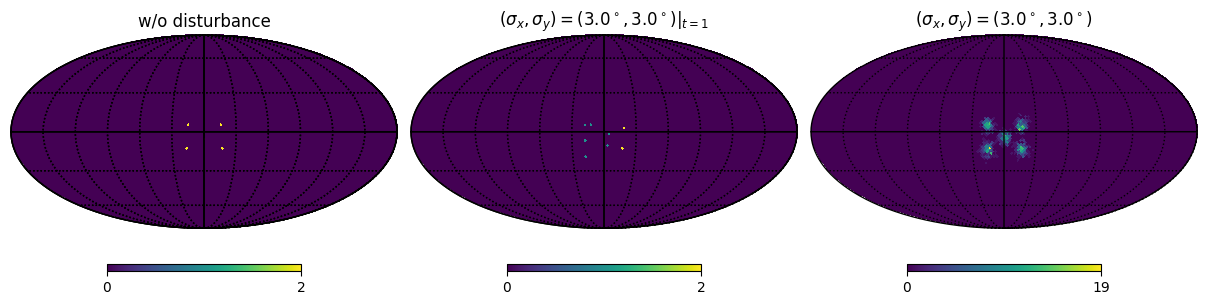

In [14]:
nside = 32
hitmap = get_hitmap(
    nside,
    pointings[
        :,
        :1,
        :,
    ],
)

plt.figure(figsize=(12, 7))
hp.mollview(hitmap, sub=(1, 3, 1), title="w/o disturbance")
hp.graticule()

hitmap_sys_t1 = get_hitmap(
    nside,
    pointings_list[
        :,
        :1,
        :,
    ],
)
hp.mollview(
    hitmap_sys_t1,
    sub=(1, 3, 2),
    title=f"$(\sigma_x,\sigma_y)=({noise_sigma_deg}^\circ, {noise_sigma_deg}^\circ)$"
    + "$|_{t=1}$",
)
hp.graticule()

hitmap_sys = get_hitmap(nside, pointings_list)
hp.mollview(
    hitmap_sys,
    sub=(1, 3, 3),
    title=f"$(\sigma_x,\sigma_y)=({noise_sigma_deg}^\circ, {noise_sigma_deg}^\circ)$",
)
hp.graticule()

## Spacecraft / time-independent / global offset


In [15]:
# 'x': perpendicular to the scan direction
# 'z': parallel to the scan direction

axes = ["x", "y", "z"]
pointings_list = []
global_offset_deg = 30.0

for ax in axes:
    sim_sys, dets_sys = gen_simulation_and_dets(
        telescope, duration_s, sampling_hz, random_seed
    )
    pntsys = lbs.PointingSys(sim_sys, dets_sys)

    # Specify `spacecraft` to add the global offset
    pntsys.spacecraft.add_offset(np.deg2rad(global_offset_deg), ax)

    sim_sys.create_observations(detectors=dets_sys)
    lbs.prepare_pointings(
        sim_sys.observations,
        sim_sys.instrument,
        sim_sys.spin2ecliptic_quats,
        hwp=sim_sys.hwp,
    )

    pointings_sys, hwp_angle = sim_sys.observations[0].get_pointings("all")
    pointings_list.append(pointings_sys)

Note that in the FP example, the rotation was attached with respect to the boresight, but in the spacecraft coordinates, the spin axis is the reference. In particular, the $x$-axis offset is perpendicular to the scan direction and the $z$-axis offset is parallel to the scan direction, which changes the physical situation.


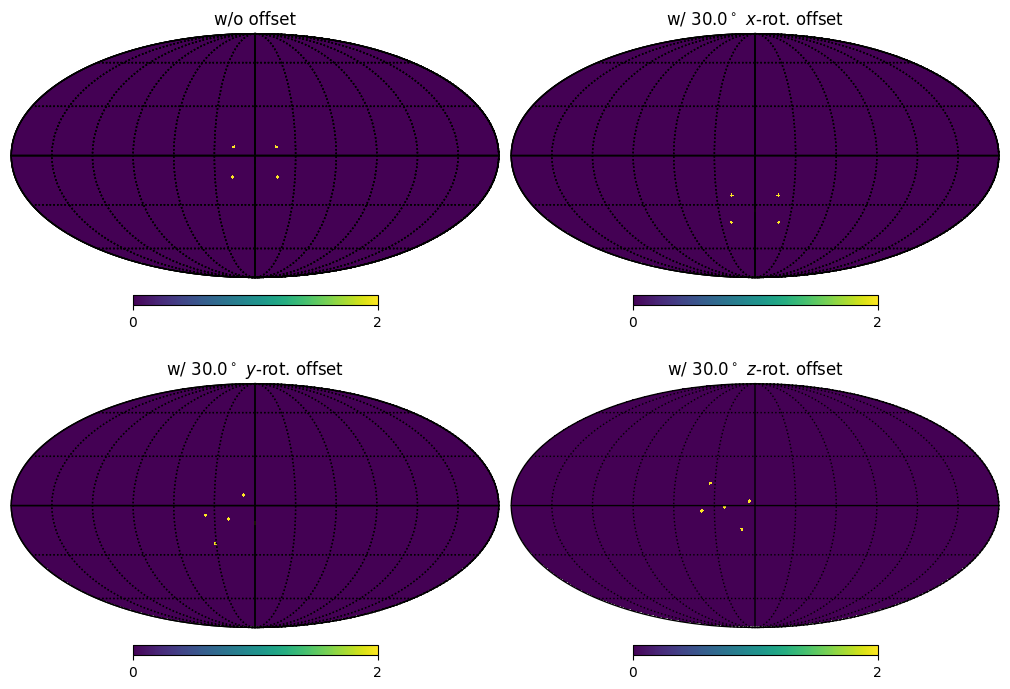

In [16]:
nside = 32
hitmap = get_hitmap(
    nside,
    pointings[
        :,
        :1,
        :,
    ],
)

plt.figure(figsize=(10, 7))
hp.mollview(hitmap, sub=(2, 2, 1), title="w/o offset")
hp.graticule()
for i, ax in enumerate(axes):
    hitmap_sys = get_hitmap(nside, pointings_list[i][:, :1])
    hp.mollview(
        hitmap_sys,
        sub=(2, 2, i + 2),
        title=rf"w/ {global_offset_deg}$^\circ$ ${ax}$-rot. offset",
    )
    hp.graticule()

## Spacecraft / time-dependent / global disturbance


In [17]:
duration_s = 10
sampling_hz = 10.0

sim_sys, dets_sys = gen_simulation_and_dets(
    telescope, duration_s, sampling_hz, random_seed, scan_strategy=False
)

nquats = sim_sys.spin2ecliptic_quats.quats.shape[0]

noise_rad_array_x = np.zeros(nquats)
noise_rad_array_z = np.zeros(nquats)
noise_sigma_deg = 3.0

# make a white noise with the unit of radian.
lbs.add_white_noise(
    noise_rad_array_x, sigma=np.deg2rad(noise_sigma_deg), random=sim_sys.random
)
lbs.add_white_noise(
    noise_rad_array_z, sigma=np.deg2rad(noise_sigma_deg), random=sim_sys.random
)

pntsys = lbs.PointingSys(sim_sys, dets_sys)

# Add the white noise to the spacecraft
pntsys.spacecraft.add_disturb(noise_rad_array_x, "x")
pntsys.spacecraft.add_disturb(noise_rad_array_z, "z")

sim_sys.create_observations(detectors=dets_sys)
lbs.prepare_pointings(
    sim_sys.observations,
    sim_sys.instrument,
    sim_sys.spin2ecliptic_quats,
    hwp=sim_sys.hwp,
)

pointings_list, _ = sim_sys.observations[0].get_pointings("all")

We can see the disturbed pointings in the right hitmap.


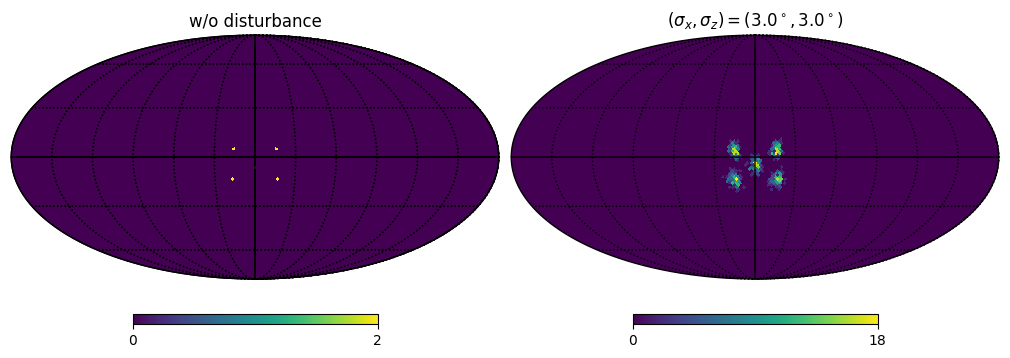

In [18]:
nside = 32
hitmap = get_hitmap(
    nside,
    pointings[
        :,
        :1,
        :,
    ],
)

plt.figure(figsize=(10, 7))
hp.mollview(hitmap, sub=(1, 2, 1), title="w/o disturbance")
hp.graticule()

hitmap_sys = get_hitmap(nside, pointings_list)
hp.mollview(
    hitmap_sys,
    sub=(1, 2, 2),
    title=f"$(\sigma_x,\sigma_z)=({noise_sigma_deg}^\circ, {noise_sigma_deg}^\circ)$",
)
hp.graticule()

# Rotational disturbance due to the HWP

## Example of wedged HWP pointing systematics


In [19]:
duration_s = 60
sampling_hz = 19.0
start_time = 0
hwp_rpm = 3

sim_sys, dets_sys = gen_simulation_and_dets(
    telescope, duration_s, sampling_hz, random_seed, hwp_rpm=hwp_rpm, scan_strategy=True
)
# Define the instance of the `PointingSys`
pntsys = lbs.PointingSys(sim_sys, dets_sys)
refractive_idx = 3.1 # refractive index of the saphire
wedge_angle_deg = 3 # wedge angle of the HWP, for the visulization it is set to big number to see the effect.
wedge_angle_rad = np.deg2rad(wedge_angle_deg)

# Set the pointing tilt angle from the expected pointing direction i.e. it is a deviation of the pointing direction.
# if pntsys.hwp.tilt_angle_rad = 0.0, the pointing is the same as the expected pointing direction.
# Now, we determin the deviation angle by the wedge angle and the refractive index of the HWP.
pntsys.hwp.tilt_angle_rad = pntsys.hwp.get_wedgeHWP_pointing_shift_angle(wedge_angle_rad, refractive_idx)

# Set the HWP rotation speed and the initial tilt (wedge direction) corresponding to the phase of the pointing deviation angle.
pntsys.hwp.ang_speed_radpsec = sim_sys.instrument.hwp_rpm * 2 * np.pi / 60
pntsys.hwp.tilt_phase_rad = 0.0

# Add the HWP rotation disturbance
pntsys.hwp.add_hwp_rot_disturb()

sim_sys.create_observations(detectors=dets_sys)
lbs.prepare_pointings(
    sim_sys.observations,
    sim_sys.instrument,
    sim_sys.spin2ecliptic_quats,
    hwp=sim_sys.hwp,
)

pointings_list, hwpang = sim_sys.observations[0].get_pointings('all')

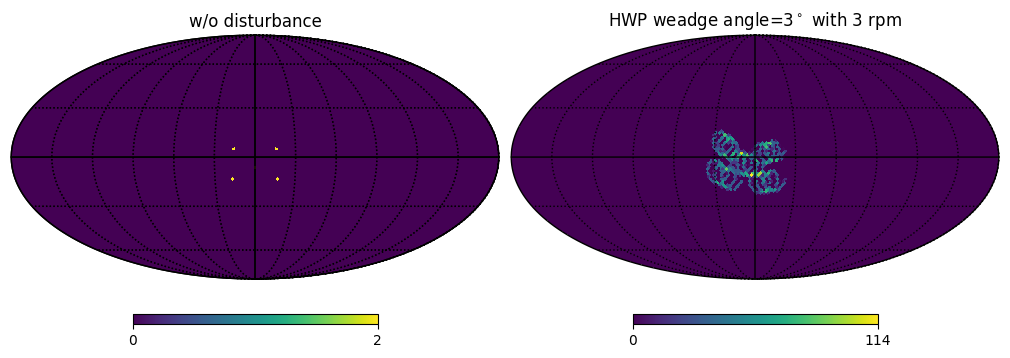

In [20]:
nside = 32
hitmap = get_hitmap(
    nside,
    pointings[
        :,
        :1,
        :,
    ],
)

plt.figure(figsize=(10, 7))
hp.mollview(hitmap, sub=(1, 2, 1), title="w/o disturbance")
hp.graticule()

hitmap_sys = get_hitmap(nside, pointings_list)
hp.mollview(
    hitmap_sys,
    sub=(1, 2, 2),
    title=f"HWP weadge angle={wedge_angle_deg}$^\circ$ with {hwp_rpm} rpm",
)
hp.graticule()

## TOD generation

Now, we demonstrate an example of TOD generation with the pointing systematics.
Let's redefine the `Simulation` and list of detectors.


In [21]:
telescope = "LFT"
channel = "L4-140"
detlist = ["000_001_017_QB_140_T", "000_001_017_QB_140_B"]

start_time = 0
imo_version = "vPTEP"
imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)

duration_s = 1000
sampling_hz = 19.0
random_seed = 12345
nside = 512


def gen_sim_and_dets_from_imo(telescope, duration_s, sampling_hz, random_seed, hwp_rpm=None, scan_strategy=True):
    """Generate a simulation and detectors with a argument of scan_strategy.
    If scan_strategy is True, the scanning strategy is set by the IMO file.
    If scan_strategy is False, the spacecraft stops spinning and precession.
    """
    sim = lbs.Simulation(
        start_time=start_time, duration_s=duration_s, random_seed=random_seed
    )
    sim.set_scanning_strategy(
        imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/",
        delta_time_s=1.0 / sampling_hz,
    )
    if scan_strategy:
        sim.set_scanning_strategy(
            imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/",
            delta_time_s=1.0 / sampling_hz,
        )
    else:
        sim.set_scanning_strategy(
            scanning_strategy=lbs.SpinningScanningStrategy(
                spin_sun_angle_rad=np.deg2rad(45.0),
                spin_rate_hz=0.0,
                precession_rate_hz=0.0,
            ),
            delta_time_s=1.0 / sampling_hz,
        )
    sim.set_instrument(
        lbs.InstrumentInfo.from_imo(
            imo,
            f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
        )
    )
    if hwp_rpm is not None:
        sim.set_hwp(lbs.IdealHWP(hwp_rpm * 2 * np.pi / 60))
        sim.instrument.hwp_rpm = hwp_rpm
    else:
        sim.set_hwp(lbs.IdealHWP(sim.instrument.hwp_rpm * 2 * np.pi / 60))

    dets = []
    for n_det in detlist:
        det = lbs.DetectorInfo.from_imo(
            url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
            imo=imo,
        )
        det.sampling_rate_hz = sampling_hz
        dets.append(det)

    return sim, dets

In [22]:
# loading channel info
ch_info = []
ch_info.append(
    lbs.FreqChannelInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
        imo=imo,
    )
)

# let's make an input CMB+foreground map
# this sets the parameters for the generation of the map
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    make_fg=False,
    seed_cmb=1,  # set this seed if you want to fix the CMB realization
    fg_models=[
        "pysm_synch_0",
        "pysm_freefree_1",
        "pysm_dust_0",
    ],  # set the FG models you want
    gaussian_smooth=True,  # if True, smooths the input map by the beam of the channel
    bandpass_int=False,  # if True, integrates over the top-hat bandpass of the channel
    nside=nside,
    units="K_CMB",
    maps_in_ecliptic=False,
)

mbs = lbs.Mbs(
    simulation=sim,
    parameters=Mbsparams,
    channel_list=ch_info,
    # detector_list = dets      #use detector_list instead of channel_list if your sim has detectors
    # from different channels. It would produce a map for each detector in dets
)
maps = mbs.run_all()[0]  # generates the map as a dictionary

[2024-10-31 15:17:34,902 INFO MPI#0000] generating and saving cmb simulations


[2024-10-31 15:17:35,681 INFO MPI#0000] Access data from /media/heavybird/IOdata_HDD/Ishino_Lab/M2/takase/program/litebird/litebird_sims/point_syst_wedgeHWP/litebird_sim/notebooks/cmb/0000/cmb_0000_date_241031.fits


## Example of the pointing offset in the spacecraft


In [23]:
# Define `Simulation` and `List[Detector]` without pointing systematics.
sim, dets = gen_sim_and_dets_from_imo(telescope, duration_s, sampling_hz, random_seed)
# Define `Simulation` and `List[Detector]` to be injected pointing systematics.
sim_sys, dets_sys = gen_sim_and_dets_from_imo(
    telescope, duration_s, sampling_hz, random_seed
)
# make `PointingSys` instance
pntsys = lbs.PointingSys(sim_sys, dets_sys)

In [24]:
# Add the global offset to the focal plane
global_offset_deg = 0.1
axis = "x"
pntsys.spacecraft.add_offset(np.deg2rad(global_offset_deg), axis)

In [25]:
# create the observations
sim.create_observations(detectors=dets)
sim_sys.create_observations(detectors=dets_sys)

# prepare the pointing
sim.prepare_pointings()
sim_sys.prepare_pointings()

# scan the map in the observations
lbs.scan_map_in_observations(
    sim.observations,
    maps=maps,
    input_map_in_galactic=True,
    interpolation="linear",  # TOD will be generated by bi-linear interpolation of the map
)

lbs.scan_map_in_observations(
    sim_sys.observations,
    maps=maps,
    input_map_in_galactic=True,
    interpolation="linear",
)

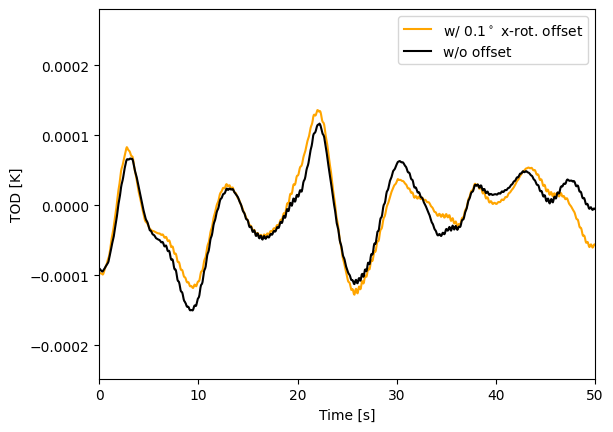

In [26]:
time = sim.observations[0].get_times()
plt.plot(time, sim_sys.observations[0].tod[0],
         "-",
         label=f"w/ {global_offset_deg}$^\circ$ {axis}-rot. offset",
         color="orange"
         )

plt.plot(time, sim.observations[0].tod[0],
         "-",
         label="w/o offset",
         color="black"
         )

plt.xlim(0,50)
plt.xlabel("Time [s]")
plt.ylabel("TOD [K]")
plt.legend();

## Example of the random disturbance in the spacecraft


In [27]:
# Define `Simulation` and `List[Detector]` without pointing systematics.
sim, dets = gen_sim_and_dets_from_imo(telescope, duration_s, sampling_hz, random_seed)
# Define `Simulation` and `List[Detector]` to be injected pointing systematics.
sim_sys, dets_sys = gen_sim_and_dets_from_imo(
    telescope, duration_s, sampling_hz, random_seed
)
pntsys = lbs.PointingSys(sim_sys, dets_sys)

In [28]:
nquats = sim_sys.spin2ecliptic_quats.quats.shape[0]

noise_rad_array_x = np.zeros(nquats)
noise_rad_array_y = np.zeros(nquats)
noise_sigma_deg = 0.05

# make a white noise with the unit of radian.
lbs.add_white_noise(
    noise_rad_array_x, sigma=np.deg2rad(noise_sigma_deg), random=sim_sys.random
)
lbs.add_white_noise(
    noise_rad_array_y, sigma=np.deg2rad(noise_sigma_deg), random=sim_sys.random
)
# Add the white noise to the focal plane
pntsys.spacecraft.add_disturb(noise_rad_array_x, "x")
pntsys.spacecraft.add_disturb(noise_rad_array_y, "y")

In [29]:
# create the observations
sim.create_observations(detectors=dets)
sim_sys.create_observations(detectors=dets_sys)

# prepare the pointing
sim.prepare_pointings()
sim_sys.prepare_pointings()

# scan the map in the observations
lbs.scan_map_in_observations(
    sim.observations,
    maps=maps,
    input_map_in_galactic=True,
    interpolation="linear",  # TOD will be generated by bi-linear interpolation of the map
)

lbs.scan_map_in_observations(
    sim_sys.observations,
    maps=maps,
    input_map_in_galactic=True,
    interpolation="linear",
)

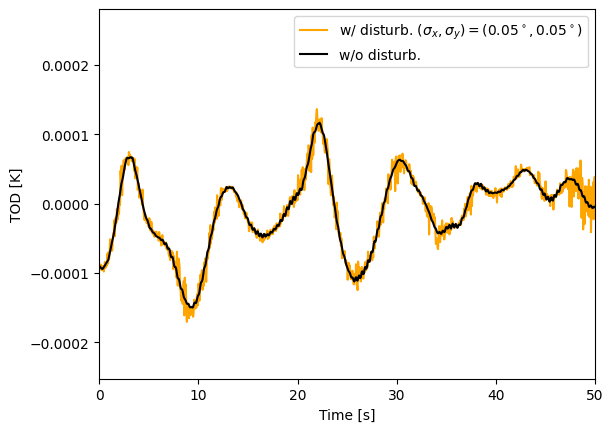

In [30]:
time = sim.observations[0].get_times()
plt.plot(time, sim_sys.observations[0].tod[0],
         "-",
         label=f"w/ disturb. $(\sigma_x, \sigma_y)=({noise_sigma_deg}^\circ, {noise_sigma_deg}^\circ)$",
         color="orange"
         )

plt.plot(time, sim.observations[0].tod[0],
         "-",
         label="w/o disturb.",
         color="black"
         )

plt.xlim(0,50)
plt.xlabel("Time [s]")
plt.ylabel("TOD [K]")
plt.legend()

# Example of HWP wedge effect for pointings

We assume a wedged transmissive HWP here, which rotate pointings around the expected pointing direction.
Here, we set 60 rpm i.e. 1 Hz as the HWP rotation speed, so we expect it cause the $1f$-effect in TOD.


In [31]:
# Define `Simulation` and `List[Detector]` without pointing systematics.
duration_s = 1000
sampling_hz = 19.0
hwp_rpm = 60.0
scan = True
sim, dets = gen_sim_and_dets_from_imo(
    telescope, duration_s, sampling_hz, random_seed,
    hwp_rpm=hwp_rpm, scan_strategy=scan
    )

# Define `Simulation` and `List[Detector]` to be injected pointing systematics.
sim_sys, dets_sys = gen_sim_and_dets_from_imo(
    telescope, duration_s, sampling_hz, random_seed,
    hwp_rpm=hwp_rpm, scan_strategy=scan
)
pntsys = lbs.PointingSys(sim_sys, dets_sys)

wedge_angle_arcmin = 1.0
refractive_idx = 3.1
wedge_angle_rad = np.deg2rad(wedge_angle_arcmin / 60)

pntsys.hwp.tilt_angle_rad = pntsys.hwp.get_wedgeHWP_pointing_shift_angle(wedge_angle_rad, refractive_idx)
pntsys.hwp.ang_speed_radpsec = hwp_rpm * 2 * np.pi / 60
pntsys.hwp.tilt_phase_rad = 0
pntsys.hwp.add_hwp_rot_disturb()

# create the observations
sim.create_observations(detectors=dets)
sim_sys.create_observations(detectors=dets_sys)

sim.prepare_pointings()
sim_sys.prepare_pointings()
lbs.precompute_pointings(sim.observations)
lbs.precompute_pointings(sim_sys.observations)

# /!\ Bug warning

The wedge effect is expected to rotate $(\theta, \phi)$ only, it does not rotate $\psi$, the crossing angles.
However, the current version of the `.add_hwp_rot_disturb()` changes $\psi$. This behavior must be fixed though Yusuke is stackinig how to address it.
The bug reports is bellow:


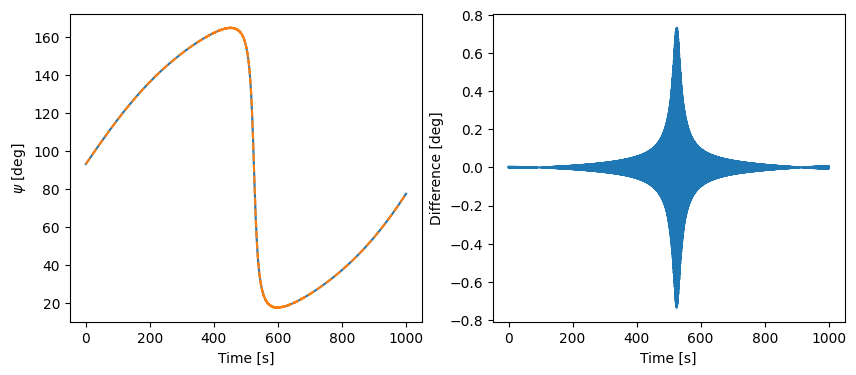

In [32]:
time = sim.observations[0].get_times()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

psi = np.rad2deg(sim.observations[0].pointing_matrix[0,:,2]) # psi w/o systematics
psi_sys = np.rad2deg(sim_sys.observations[0].pointing_matrix[0,:,2]) # psi w/ systematics

ax[0].plot(time, psi, label = "w/o disturb.")
ax[0].plot(time, psi_sys, "--", label = "w/ disturb.")
ax[1].plot(time, psi - psi_sys, label = "difference")
ax[0].set_xlabel("Time [s]")
ax[1].set_xlabel("Time [s]")
ax[0].set_ylabel("$\psi$ [deg]")
ax[1].set_ylabel("Difference [deg]");

The left plot shows the timeline of $\psi$ with and without systematics disturbances.
The right plot shows the difference of them.
It must be zero, but polarization direction is also rotated by the quaternion operation to make a rotation to $\theta$ and $\phi$.
(the correspond code is pointing_sys.py L510-520)

It is dificult to modify the unexpected rotation of $\psi$ by multiplying additional quaternions in these line of code,
so I think it can be modified by subtraction after simulate $\psi$.

Currently, to avoid to use in-correct \psi in a simulation, we have to prepare the pointing without systematics.
Then, we overwrite the \psi to make TODs as below.


In [33]:
# overwrite the wrong psi by correct psi
sim_sys.observations[0].pointing_matrix[:,:,2] = sim.observations[0].pointing_matrix[:,:,2]

lbs.scan_map_in_observations(
    sim.observations,
    maps=maps,
    input_map_in_galactic=True,
    interpolation="linear",
)

lbs.scan_map_in_observations(
    sim_sys.observations,
    maps=maps,
    input_map_in_galactic=True,
    interpolation="linear",
)

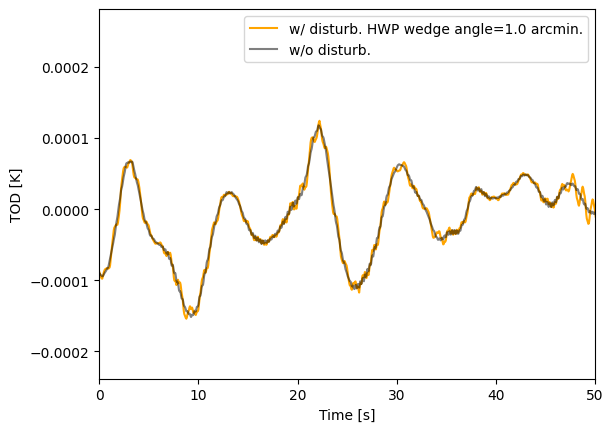

In [34]:
time = sim.observations[0].get_times()
plt.plot(time, sim_sys.observations[0].tod[0],
         "-",
         label=f"w/ disturb. HWP wedge angle={wedge_angle_arcmin} arcmin.",
         color="orange"
         )

plt.plot(time, sim.observations[0].tod[0],
         "-",
         label="w/o disturb.",
         color="black",
         alpha=0.5
         )
'''
plt.plot(time, sim.observations[0].hwp_angle,
         "-",
         label="w/o disturb.",
         color="black"
         )
'''
plt.xlim(0,50)
plt.xlabel("Time [s]")
plt.ylabel("TOD [K]")
plt.legend();

# Power spectrum of TODs

We can clealy see the $1f$ systematics peak and $4f$ modulation peak.


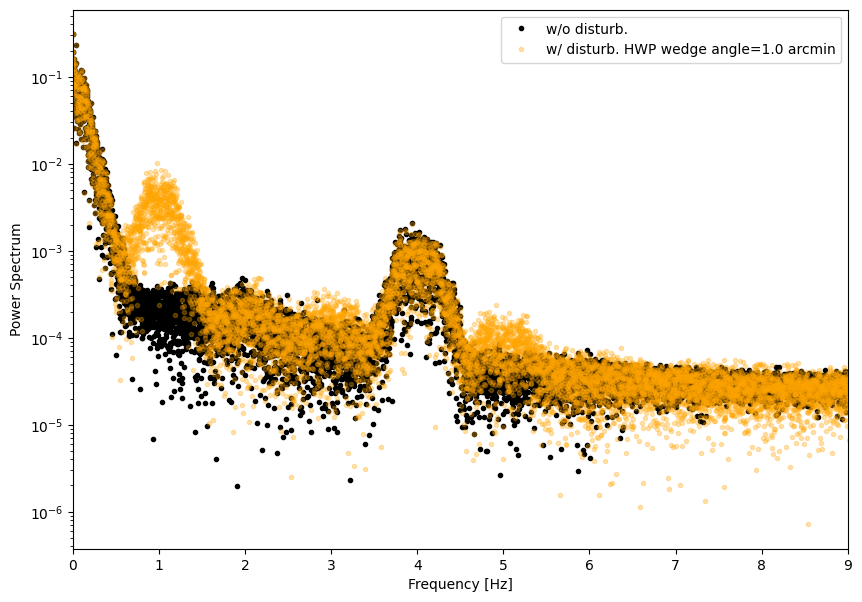

In [35]:
ps = np.fft.fft(sim.observations[0].tod[0])
ps_sys = np.fft.fft(sim_sys.observations[0].tod[0])
freqs = np.fft.fftfreq(len(ps), d=1/sampling_hz)

plt.figure(figsize=(10, 7))
plt.plot(freqs, np.abs(ps), ".", label="w/o disturb.", color="black")
plt.plot(freqs, np.abs(ps_sys), ".",
         label=f"w/ disturb. HWP wedge angle={wedge_angle_arcmin} arcmin",
         color="orange", alpha=0.3
         )
plt.yscale("log")
plt.xlim(0, 9)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectrum")
plt.legend()